In [1]:
%pip install marimo --quiet

     ---------------------------------------- 38.6/38.6 MB 1.8 MB/s eta 0:00:00
     -------------------------------------- 268.8/268.8 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 74.3/74.3 kB ? eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 633.2/633.2 kB ? eta 0:00:00
  Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
     ------------------------------------- 444.0/444.0 kB 28.9 MB/s eta 0:00:00
     ------------------------------------- 188.7/188.7 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: narwhals
    Found existing installation: narwhals 1.39.1
    Uninstalling narwhals-1.39.1:
      Successfully uninstalled narwhals-1.39.1
  Attempting uninstall: starlette
    Found existing installation: starlette 0.27.0
    Uninstalling starlette-0.27.0:
      Successfully uninstalled starlette-0.27.0
Note: you may need to restart the kernel to use updated packages.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastapi 0.104.1 requires starlette<0.28.0,>=0.27.0, but you have starlette 0.52.1 which is incompatible.

[notice] A new release of pip available: 22.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import marimo as mo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Pull-Up Training Analysis

In [3]:
# Load the data
df_raw = pd.read_csv('data/weekly_data/week_9.csv')
df_raw

,Date,Dead Hang \nSet 1 (secs),Dead Hang \nSet 2 (secs),Dead Hang \nSet 3 (secs),Average Dead \nHang (secs),Maximum \nPull-Ups,Left Forearm \nCircumference (cm),Right Forearm \nCircumference (cm),Left Biceps \nCircumference (cm),Right Biceps\nCircumference (cm),Lats Spread \nWidth (cm),Weight (kg),Perceived \nDifficulty (1-10),Unnamed: 13
0,12/3/2025,66.0,48.0,50.0,54.666667,0.0,25.0,26.0,28.0,29.0,44.0,61.0,9.0,NaN
1,12/4/2025,40.0,47.0,30.0,39.000000,0.0,25.0,26.0,28.0,29.0,44.0,60.0,10.0,Saket sa kamay shet
2,12/5/2025,55.0,45.0,40.0,46.666667,0.0,25.0,26.0,28.0,29.0,44.0,60.0,10.0,NaN
3,12/6/2025,53.0,53.0,50.0,52.000000,0.0,25.0,26.0,28.0,29.0,44.0,61.0,9.0,Napapabitaw dahil sa kamay
4,12/7/2025,66.0,58.0,47.0,57.000000,0.0,25.0,26.0,28.0,29.0,44.0,61.0,8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2/1/2026,76.0,49.0,62.0,62.333333,6.0,27.0,27.0,30.0,30.0,46.0,61.0,5.0,NaN
61,2/2/2026,79.0,72.0,70.0,73.666667,5.0,27.0,27.0,30.0,31.0,46.0,60.0,4.0,NaN
62,2/3/2026,94.0,85.0,80.0,86.333333,5.0,27.0,28.0,30.0,31.0,46.0,60.0,4.0,NaN
63,2/4/2026,84.0,92.0,81.0,85.666667,5.0,27.0,28.0,30.0,31.0,46.0,61.0,4.0,NaN


In [4]:
# Clean the data
df = df_raw.copy()

# Clean column names - remove extra whitespace and newlines
df.columns = df.columns.str.replace('\n', ' ').str.strip()

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Remove rows where all workout data is missing
workout_columns = [col for col in df.columns if col != 'Date']
df_cleaned = df.dropna(how='all', subset=workout_columns)

# Remove Notes Column
df_cleaned = df_cleaned.drop(columns=['Unnamed: 13'])

# Sort by date
df_cleaned = df_cleaned.sort_values('Date').reset_index(drop=True)

# Add day number for trend analysis
df_cleaned['Day_Number'] = range(1, len(df_cleaned) + 1)

df_cleaned

,Date,Dead Hang Set 1 (secs),Dead Hang Set 2 (secs),Dead Hang Set 3 (secs),Average Dead Hang (secs),Maximum Pull-Ups,Left Forearm Circumference (cm),Right Forearm Circumference (cm),Left Biceps Circumference (cm),Right Biceps Circumference (cm),Lats Spread Width (cm),Weight (kg),Perceived Difficulty (1-10),Day_Number
0,2025-12-03,66.0,48.0,50.0,54.666667,0.0,25.0,26.0,28.0,29.0,44.0,61.0,9.0,1
1,2025-12-04,40.0,47.0,30.0,39.000000,0.0,25.0,26.0,28.0,29.0,44.0,60.0,10.0,2
2,2025-12-05,55.0,45.0,40.0,46.666667,0.0,25.0,26.0,28.0,29.0,44.0,60.0,10.0,3
3,2025-12-06,53.0,53.0,50.0,52.000000,0.0,25.0,26.0,28.0,29.0,44.0,61.0,9.0,4
4,2025-12-07,66.0,58.0,47.0,57.000000,0.0,25.0,26.0,28.0,29.0,44.0,61.0,8.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2026-02-01,76.0,49.0,62.0,62.333333,6.0,27.0,27.0,30.0,30.0,46.0,61.0,5.0,57
57,2026-02-02,79.0,72.0,70.0,73.666667,5.0,27.0,27.0,30.0,31.0,46.0,60.0,4.0,58
58,2026-02-03,94.0,85.0,80.0,86.333333,5.0,27.0,28.0,30.0,31.0,46.0,60.0,4.0,59
59,2026-02-04,84.0,92.0,81.0,85.666667,5.0,27.0,28.0,30.0,31.0,46.0,61.0,4.0,60


In [ ]:
# Summary Information
total_days = len(df_cleaned)
date_start = df_cleaned['Date'].min().strftime('%B %d, %Y')
date_end = df_cleaned['Date'].max().strftime('%B %d, %Y')
duration_days = (df_cleaned['Date'].max() - df_cleaned['Date'].min()).days
first_pullup_date = df_cleaned[df_cleaned['Maximum  Pull-Ups'] > 0]['Date'].iloc[0].strftime('%B %d, %Y')

print("="*60)
print("SUMMARY INFORMATION")
print("="*60)
print(f"Total workout days: {total_days}")
print(f"Date range: {date_start} to {date_end}")
print(f"Training duration: {duration_days} days")
print(f"First pull-up achieved: {first_pullup_date}")
print("="*60)

SUMMARY INFORMATION
Total workout days: 61
Date range: December 03, 2025 to February 05, 2026
Training duration: 64 days
First pull-up achieved: December 21, 2025


In [6]:
df_cleaned.drop(columns=['Date', 'Day_Number']).describe()

,Dead Hang Set 1 (secs),Dead Hang Set 2 (secs),Dead Hang Set 3 (secs),Average Dead Hang (secs),Maximum Pull-Ups,Left Forearm Circumference (cm),Right Forearm Circumference (cm),Left Biceps Circumference (cm),Right Biceps Circumference (cm),Lats Spread Width (cm),Weight (kg),Perceived Difficulty (1-10)
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,77.721311,67.524590,62.590164,69.278689,2.770492,25.967213,26.737705,28.622951,29.524590,44.442623,61.016393,6.819672
std,14.880783,13.794451,13.388275,12.870031,1.969716,0.657450,0.544721,0.636761,0.622001,0.646132,0.826475,1.554651
min,40.000000,40.000000,30.000000,39.000000,0.000000,25.000000,26.000000,28.000000,29.000000,44.000000,60.000000,3.000000
25%,66.000000,57.000000,51.000000,58.333333,0.000000,26.000000,26.000000,28.000000,29.000000,44.000000,60.000000,6.000000
50%,79.000000,69.000000,63.000000,69.333333,4.000000,26.000000,27.000000,29.000000,29.000000,44.000000,61.000000,7.000000
75%,89.000000,77.000000,76.000000,80.000000,4.000000,26.000000,27.000000,29.000000,30.000000,45.000000,62.000000,8.000000
max,109.000000,98.000000,87.000000,91.666667,6.000000,27.000000,28.000000,30.000000,31.000000,46.000000,62.000000,10.000000


In [7]:
# Export the describe() summary statistics to a CSV file
df_cleaned.drop(columns=['Date', 'Day_Number']).describe().to_csv('data/summary_statistics.csv')
print("Summary statistics saved to data/summary_statistics.csv")

Summary statistics saved to data/summary_statistics.csv


---
# Research Question 1: Does Daily Dead-Hang Training Improve Pull-Up Performance?

**H₀:** Daily dead-hang training does NOT result in statistically significant improvement in pull-up performance.

**H₁:** Daily dead-hang training DOES result in statistically significant improvement in pull-up performance.

**Significance Level:** α = 0.05

In [8]:
# Statistical Analysis for Q1
# Correlation between dead hang and pull-ups
valid_data = df_cleaned[['Average Dead  Hang (secs)', 'Maximum  Pull-Ups']].dropna()

correlation, p_value_corr = stats.pearsonr(
    valid_data['Average Dead  Hang (secs)'], 
    valid_data['Maximum  Pull-Ups']
)

# Linear regression for trend
from scipy.stats import linregress
slope, intercept, r_value, p_value_trend, std_err = linregress(
    df_cleaned['Day_Number'], 
    df_cleaned['Average Dead  Hang (secs)']
)

# Pull-up progression trend - include all data points (including zeros)
slope_pullup, intercept_pullup, r_value_pullup, p_value_pullup, std_err_pullup = linregress(
    df_cleaned['Day_Number'], 
    df_cleaned['Maximum  Pull-Ups']
)

q1_results = {
    'correlation': correlation,
    'p_value_corr': p_value_corr,
    'slope': slope,
    'p_value_trend': p_value_trend,
    'r_squared': r_value**2,
    'slope_pullup': slope_pullup,
    'p_value_pullup': p_value_pullup,
    'r_squared_pullup': r_value_pullup**2
}

In [20]:
print("="*60)
print("STATISTICAL RESULTS - QUESTION 1")
print("="*60)
print("\nCorrelation Analysis:")
print(f"  Pearson Correlation (Dead Hang vs Pull-Ups): r = {correlation:.3f}")
print(f"  P-value: {p_value_corr:.2e}")
print(f"  Interpretation: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.5 else 'Weak'} positive correlation")
print("\nTrend Analysis (Dead Hang):")
print(f"  Improvement Rate: {slope:.3f} seconds per day")
print(f"  R²: {r_value**2:.3f} ({r_value**2*100:.1f}% variance explained)")
print(f"  P-value (trend): {p_value_trend:.2e}")
print("\nPull-Up Performance:")
print(f"  Improvement Rate: {slope_pullup:.4f} reps per day")
print(f"  R²: {r_value_pullup**2:.3f}")
print(f"  P-value (pull-up trend): {p_value_pullup}")
print("\nConclusion:")
if p_value_corr < 0.05 and p_value_trend < 0.05 and p_value_pullup < 0.05:
    print("  ✓ REJECT NULL HYPOTHESIS")
    print("  Dead-hang training shows statistically significant")
    print("  improvement in pull-up performance (p < 0.05)")
else:
    print("  ✗ FAIL TO REJECT NULL HYPOTHESIS")
print("="*60)

STATISTICAL RESULTS - QUESTION 1

Correlation Analysis:
  Pearson Correlation (Dead Hang vs Pull-Ups): r = 0.751
  P-value: 3.09e-12
  Interpretation: Strong positive correlation

Trend Analysis (Dead Hang):
  Improvement Rate: 0.468 seconds per day
  R²: 0.416 (41.6% variance explained)
  P-value (trend): 1.97e-08

Pull-Up Performance:
  Improvement Rate: 0.0949 reps per day
  R²: 0.731
  P-value (pull-up trend): 1.7847428585017094e-18

Conclusion:
  ✓ REJECT NULL HYPOTHESIS
  Dead-hang training shows statistically significant
  improvement in pull-up performance (p < 0.05)


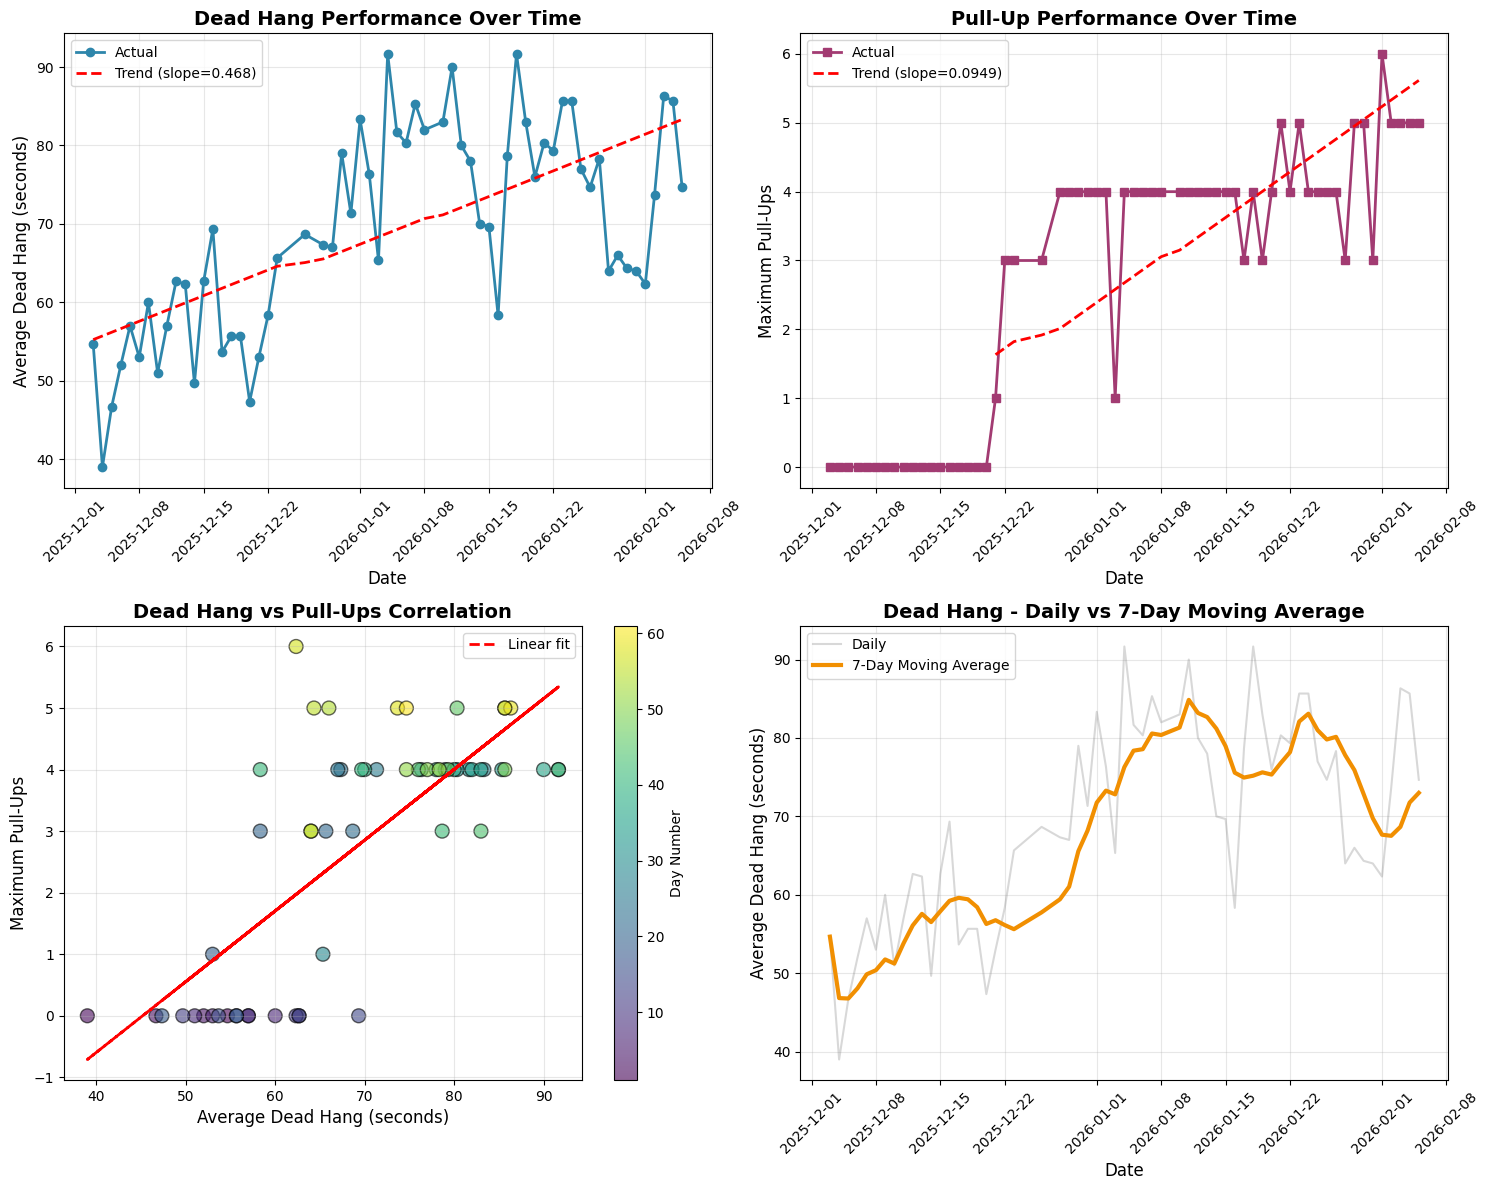

In [10]:
# Visualization for Q1
def create_q1_visualizations():
    fig1, axes1 = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Dead Hang Progress Over Time
    ax1 = axes1[0, 0]
    ax1.plot(df_cleaned['Date'], df_cleaned['Average Dead  Hang (secs)'], 
             marker='o', linewidth=2, markersize=6, color='#2E86AB', label='Actual')
    # Add trend line
    x_vals = df_cleaned['Day_Number']
    y_vals = intercept + slope * x_vals
    ax1.plot(df_cleaned['Date'], y_vals, '--', color='red', linewidth=2, label=f'Trend (slope={slope:.3f})')
    ax1.set_title('Dead Hang Performance Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Average Dead Hang (seconds)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # 2. Pull-Ups Progress Over Time
    ax2 = axes1[0, 1]
    ax2.plot(df_cleaned['Date'], df_cleaned['Maximum  Pull-Ups'], 
             marker='s', linewidth=2, markersize=6, color='#A23B72', label='Actual')
    # Add trend line for pull-ups
    pullup_mask = df_cleaned['Maximum  Pull-Ups'] > 0
    if pullup_mask.any():
        x_pullup = df_cleaned[pullup_mask]['Day_Number']
        y_pullup_trend = intercept_pullup + slope_pullup * x_pullup
        ax2.plot(df_cleaned[pullup_mask]['Date'], y_pullup_trend, '--', 
                color='red', linewidth=2, label=f'Trend (slope={slope_pullup:.4f})')
    ax2.set_title('Pull-Up Performance Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Maximum Pull-Ups', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # 3. Correlation Scatter Plot
    ax3 = axes1[1, 0]
    scatter = ax3.scatter(df_cleaned['Average Dead  Hang (secs)'], 
                         df_cleaned['Maximum  Pull-Ups'],
                         c=df_cleaned['Day_Number'], cmap='viridis', 
                         s=100, alpha=0.6, edgecolors='black')
    # Add trend line
    z = np.polyfit(df_cleaned['Average Dead  Hang (secs)'], df_cleaned['Maximum  Pull-Ups'], 1)
    p = np.poly1d(z)
    ax3.plot(df_cleaned['Average Dead  Hang (secs)'], 
             p(df_cleaned['Average Dead  Hang (secs)']), 
             "r--", linewidth=2, label=f'Linear fit')
    ax3.set_title('Dead Hang vs Pull-Ups Correlation', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Average Dead Hang (seconds)', fontsize=12)
    ax3.set_ylabel('Maximum Pull-Ups', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Day Number')

    # 4. Weekly Rolling Average
    ax4 = axes1[1, 1]
    df_cleaned['Dead_Hang_MA7'] = df_cleaned['Average Dead  Hang (secs)'].rolling(window=7, min_periods=1).mean()
    ax4.plot(df_cleaned['Date'], df_cleaned['Average Dead  Hang (secs)'], 
             alpha=0.3, color='gray', label='Daily')
    ax4.plot(df_cleaned['Date'], df_cleaned['Dead_Hang_MA7'], 
             linewidth=3, color='#F18F01', label='7-Day Moving Average')
    ax4.set_title('Dead Hang - Daily vs 7-Day Moving Average', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Average Dead Hang (seconds)', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig1

fig1 = create_q1_visualizations()

---
# Research Question 2: Body Composition & Performance

**H₀:** Changes in body composition or muscle size are NOT significantly associated with improvements in pull-up performance.

**H₁:** Changes in body composition or muscle size ARE significantly associated with improvements in pull-up performance.

**Significance Level:** α = 0.05

In [11]:
# Statistical Analysis for Q2
# Calculate correlations with pull-up performance
body_metrics = [
    'Left Forearm  Circumference (cm)',
    'Right Forearm  Circumference (cm)',
    'Left Biceps  Circumference (cm)',
    'Right Biceps Circumference (cm)',
    'Lats Spread  Width (cm)',
    'Weight (kg)'
]

correlations_q2 = {}
for metric in body_metrics:
    valid = df_cleaned[[metric, 'Maximum  Pull-Ups']].dropna()
    if len(valid) > 2:
        corr, pval = stats.pearsonr(valid[metric], valid['Maximum  Pull-Ups'])
        correlations_q2[metric] = {'correlation': corr, 'p_value': pval}

# Create correlation dataframe
corr_df = pd.DataFrame(correlations_q2).T
print(corr_df['p_value']) 
corr_df = corr_df.sort_values('correlation', ascending=False)

# Calculate changes over time
first_measurements = df_cleaned.iloc[0]
last_measurements = df_cleaned.iloc[-1]

changes = {}
for metric in body_metrics:
    start_val = first_measurements[metric]
    end_val = last_measurements[metric]
    change = end_val - start_val
    pct_change = (change / start_val * 100) if start_val != 0 else 0
    changes[metric] = {'start': start_val, 'end': end_val, 'change': change, 'pct_change': pct_change}

changes_df = pd.DataFrame(changes).T
changes_df = changes_df.round(2)

Left Forearm  Circumference (cm)     6.155592e-13
Right Forearm  Circumference (cm)    2.442581e-10
Left Biceps  Circumference (cm)      3.219782e-11
Right Biceps Circumference (cm)      3.209502e-09
Lats Spread  Width (cm)              5.067289e-07
Weight (kg)                          2.626021e-01
Name: p_value, dtype: float64


## Statistical Results - Question 2

### Correlation with Pull-Up Performance

In [12]:
corr_df

,correlation,p_value
Left Forearm Circumference (cm),0.766299,6.155592e-13
Left Biceps Circumference (cm),0.727152,3.219782e-11
Right Forearm Circumference (cm),0.704103,2.442581e-10
Right Biceps Circumference (cm),0.671260,3.209502e-09
Lats Spread Width (cm),0.591876,5.067289e-07
Weight (kg),0.145682,2.626021e-01


### Body Composition Changes

In [13]:
changes_df

,start,end,change,pct_change
Left Forearm Circumference (cm),25.0,27.0,2.0,8.00
Right Forearm Circumference (cm),26.0,28.0,2.0,7.69
Left Biceps Circumference (cm),28.0,30.0,2.0,7.14
Right Biceps Circumference (cm),29.0,31.0,2.0,6.90
Lats Spread Width (cm),44.0,46.0,2.0,4.55
Weight (kg),61.0,61.0,0.0,0.00


### Conclusion

**REJECT NULL HYPOTHESIS**

Found 5 body metric(s) with statistically significant correlation to pull-up performance (p < 0.05):

In [14]:
significant_correlations = corr_df[corr_df['p_value'] < 0.05]
significant_correlations

,correlation,p_value
Left Forearm Circumference (cm),0.766299,6.155592e-13
Left Biceps Circumference (cm),0.727152,3.219782e-11
Right Forearm Circumference (cm),0.704103,2.442581e-10
Right Biceps Circumference (cm),0.671260,3.209502e-09
Lats Spread Width (cm),0.591876,5.067289e-07


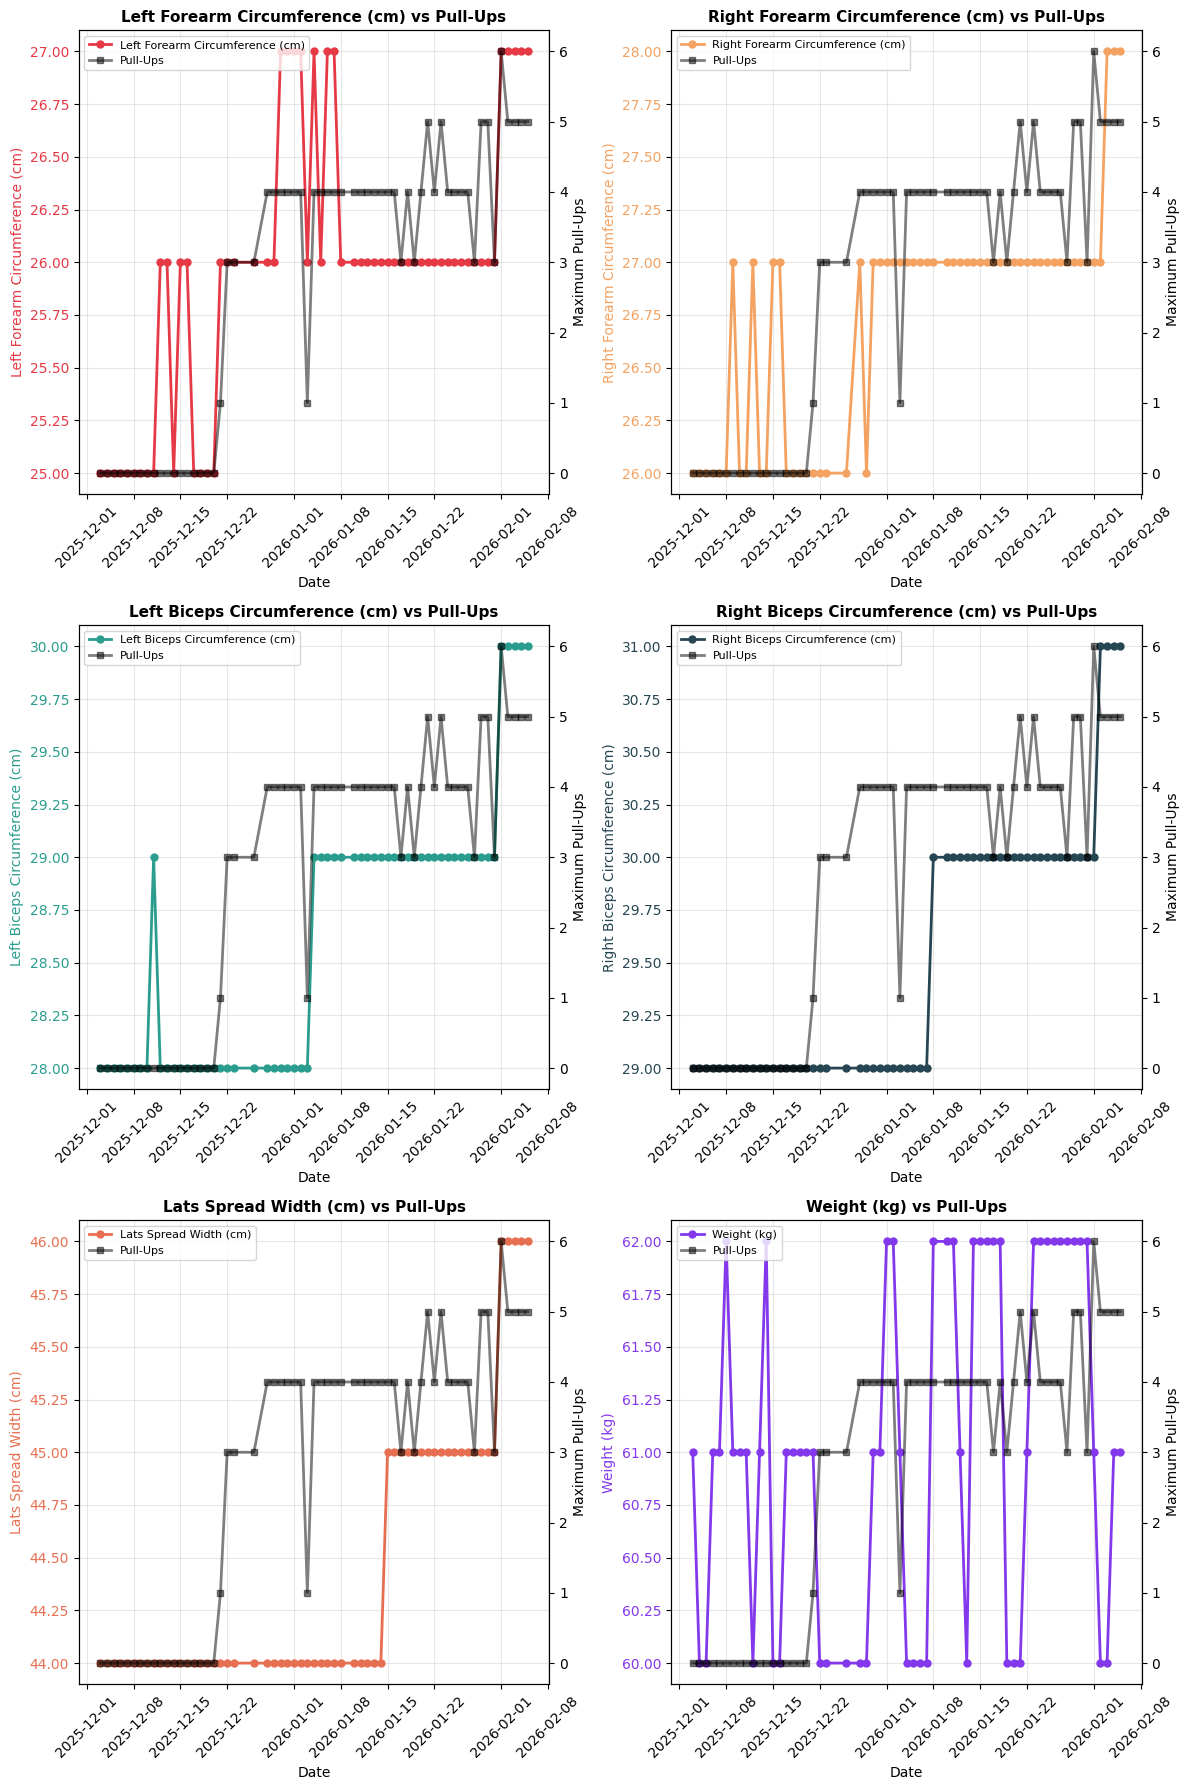

In [15]:
# Visualization for Q2
def create_q2_visualizations():
    fig2, axes2 = plt.subplots(3, 2, figsize=(12, 18))
    axes2 = axes2.flatten()

    colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653', '#E76F51', '#8338EC']

    for idx, metric in enumerate(body_metrics):
        ax = axes2[idx]
        ax2_twin = ax.twinx()

        # Plot body metric on left axis
        line1 = ax.plot(df_cleaned['Date'], df_cleaned[metric], 
                       marker='o', linewidth=2, markersize=5, 
                       color=colors[idx], label=metric.replace('  ', ' '))
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel(metric.replace('  ', ' '), fontsize=10, color=colors[idx])
        ax.tick_params(axis='y', labelcolor=colors[idx])
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

        # Plot pull-ups on right axis
        line2 = ax2_twin.plot(df_cleaned['Date'], df_cleaned['Maximum  Pull-Ups'], 
                             marker='s', linewidth=2, markersize=5, 
                             color='black', alpha=0.5, label='Pull-Ups')
        ax2_twin.set_ylabel('Maximum Pull-Ups', fontsize=10)

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='upper left', fontsize=8) 

        ax.set_title(f'{metric.replace("  ", " ")} vs Pull-Ups', fontsize=11, fontweight='bold')

    plt.tight_layout()
    return fig2

fig2 = create_q2_visualizations()

---
#  Additional Insights

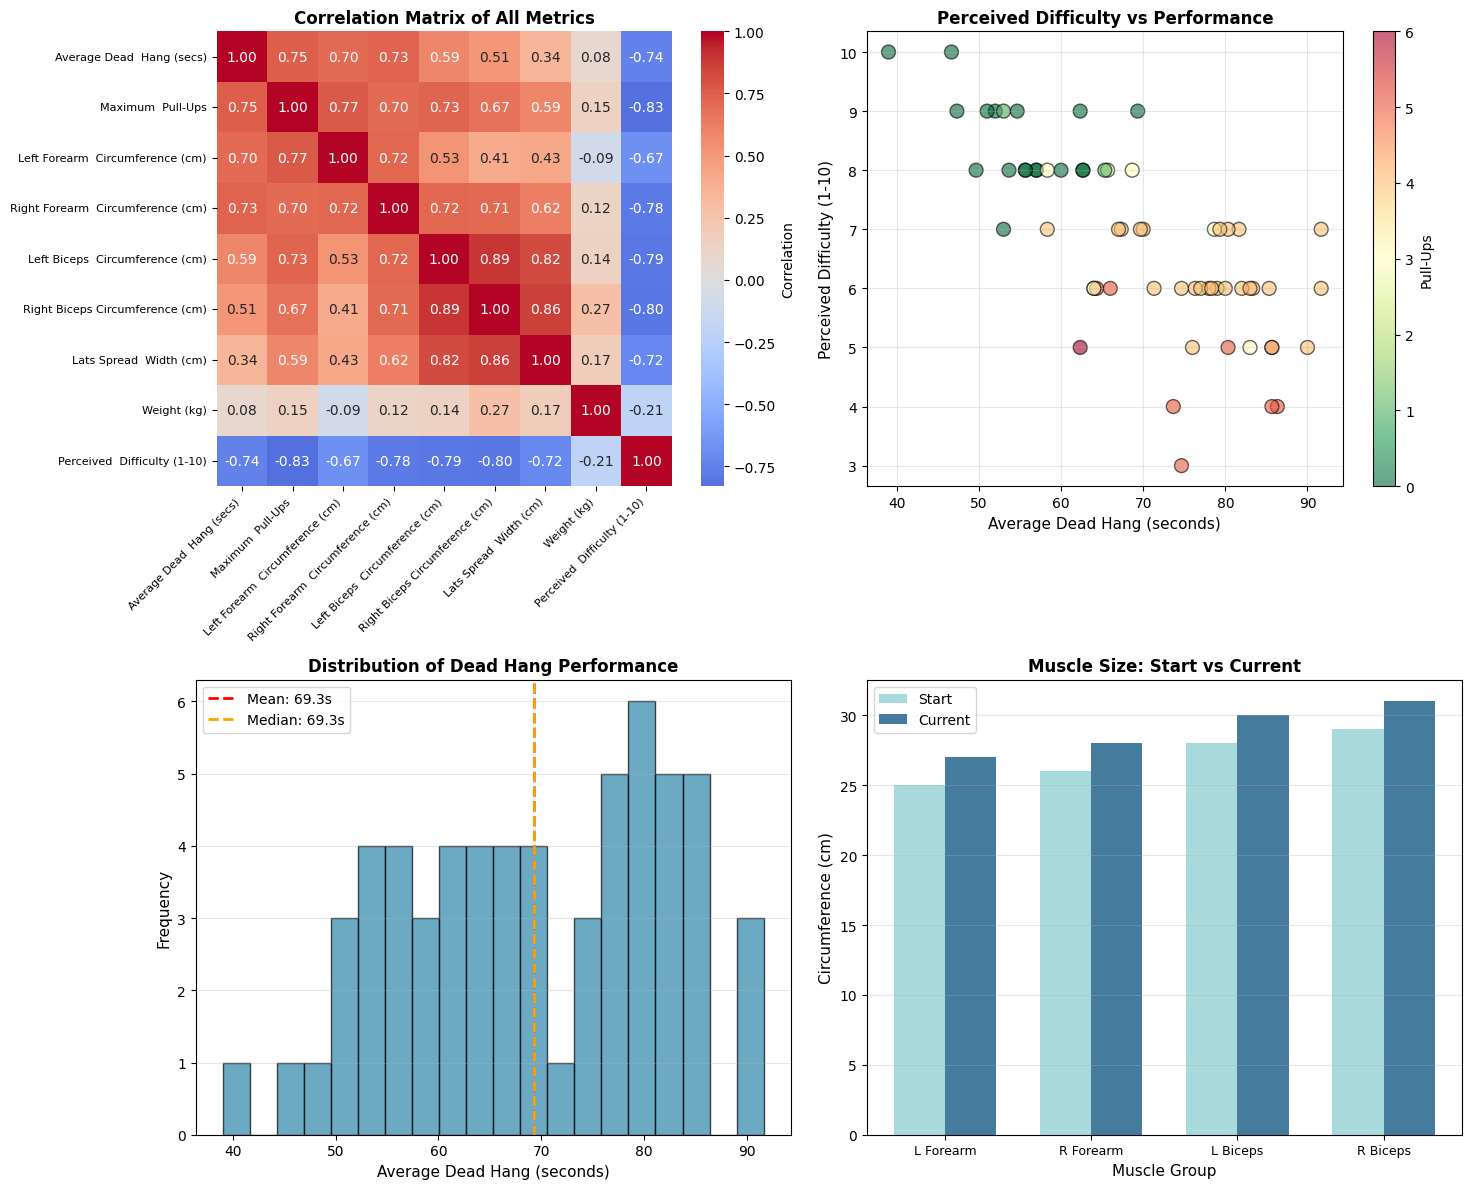

In [16]:
# Additional visualizations
def create_additional_insights():
    fig3, axes3 = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Heatmap of correlations
    ax_heat = axes3[0, 0]
    correlation_matrix = df_cleaned[[
        'Average Dead  Hang (secs)',
        'Maximum  Pull-Ups',
        'Left Forearm  Circumference (cm)',
        'Right Forearm  Circumference (cm)',
        'Left Biceps  Circumference (cm)',
        'Right Biceps Circumference (cm)',
        'Lats Spread  Width (cm)',
        'Weight (kg)',
        'Perceived  Difficulty (1-10)'
    ]].corr()

    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, ax=ax_heat, cbar_kws={'label': 'Correlation'})
    ax_heat.set_title('Correlation Matrix of All Metrics', fontsize=12, fontweight='bold')
    plt.setp(ax_heat.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax_heat.get_yticklabels(), rotation=0, fontsize=8)

    # 2. Perceived Difficulty vs Performance
    ax_diff = axes3[0, 1]
    scatter_diff = ax_diff.scatter(df_cleaned['Average Dead  Hang (secs)'], 
                                   df_cleaned['Perceived  Difficulty (1-10)'],
                                   c=df_cleaned['Maximum  Pull-Ups'], 
                                   s=100, cmap='RdYlGn_r', alpha=0.6, edgecolors='black')
    ax_diff.set_xlabel('Average Dead Hang (seconds)', fontsize=11)
    ax_diff.set_ylabel('Perceived Difficulty (1-10)', fontsize=11)
    ax_diff.set_title('Perceived Difficulty vs Performance', fontsize=12, fontweight='bold')
    ax_diff.grid(True, alpha=0.3)
    plt.colorbar(scatter_diff, ax=ax_diff, label='Pull-Ups')

    # 3. Distribution of Dead Hang Times
    ax_dist = axes3[1, 0]
    ax_dist.hist(df_cleaned['Average Dead  Hang (secs)'], bins=20, 
                color='#2E86AB', alpha=0.7, edgecolor='black')
    ax_dist.axvline(df_cleaned['Average Dead  Hang (secs)'].mean(), 
                   color='red', linestyle='--', linewidth=2, label=f'Mean: {df_cleaned["Average Dead  Hang (secs)"].mean():.1f}s')
    ax_dist.axvline(df_cleaned['Average Dead  Hang (secs)'].median(), 
                   color='orange', linestyle='--', linewidth=2, label=f'Median: {df_cleaned["Average Dead  Hang (secs)"].median():.1f}s')
    ax_dist.set_xlabel('Average Dead Hang (seconds)', fontsize=11)
    ax_dist.set_ylabel('Frequency', fontsize=11)
    ax_dist.set_title('Distribution of Dead Hang Performance', fontsize=12, fontweight='bold')
    ax_dist.legend()
    ax_dist.grid(True, alpha=0.3, axis='y')

    # 4. Muscle Growth Comparison
    ax_muscle = axes3[1, 1]
    muscle_metrics = ['Left Forearm  Circumference (cm)', 'Right Forearm  Circumference (cm)',
                     'Left Biceps  Circumference (cm)', 'Right Biceps Circumference (cm)']
    start_vals = [df_cleaned[m].iloc[0] for m in muscle_metrics]
    end_vals = [df_cleaned[m].iloc[-1] for m in muscle_metrics]

    x_pos = np.arange(len(muscle_metrics))
    width = 0.35

    bars1 = ax_muscle.bar(x_pos - width/2, start_vals, width, label='Start', color='#A8DADC')
    bars2 = ax_muscle.bar(x_pos + width/2, end_vals, width, label='Current', color='#457B9D')

    ax_muscle.set_xlabel('Muscle Group', fontsize=11)
    ax_muscle.set_ylabel('Circumference (cm)', fontsize=11)
    ax_muscle.set_title('Muscle Size: Start vs Current', fontsize=12, fontweight='bold')
    ax_muscle.set_xticks(x_pos)
    ax_muscle.set_xticklabels(['L Forearm', 'R Forearm', 'L Biceps', 'R Biceps'], fontsize=9)
    ax_muscle.legend()
    ax_muscle.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig3

fig3 = create_additional_insights()

---
# Key Findings Summary

## Performance Improvements

### Dead Hang
- **Initial:** 54.7 seconds
- **Current:** 74.7 seconds
- **Improvement:** +20.0 seconds (36.6%)
- **Average improvement rate:** 0.468 seconds per day

### Pull-Ups
- **Initial:** 0 reps
- **Current:** 5 reps
- **Improvement:** +5 reps
- **First pull-up achieved on day:** 19
- **Total pull-ups achieved from start:** 169 reps

In [17]:
dead_hang_improvement = df_cleaned['Average Dead  Hang (secs)'].iloc[-1] - df_cleaned['Average Dead  Hang (secs)'].iloc[0]
dead_hang_improvement_pct = (dead_hang_improvement / df_cleaned['Average Dead  Hang (secs)'].iloc[0]) * 100

pullup_start = df_cleaned['Maximum  Pull-Ups'].iloc[0]
pullup_current = df_cleaned['Maximum  Pull-Ups'].iloc[-1]
pullup_improvement = pullup_current - pullup_start

# Calculate total pull-ups achieved
total_pullups = df_cleaned['Maximum  Pull-Ups'].sum()

# Get the actual Day_Number value instead of the index
first_pullup_day = df_cleaned[df_cleaned['Maximum  Pull-Ups'] > 0]['Day_Number'].iloc[0]

print(f"Dead Hang Improvement: {dead_hang_improvement:.1f} seconds ({dead_hang_improvement_pct:.1f}%)")
print(f"Pull-Up Improvement: {pullup_improvement:.0f} reps")
print(f"First pull-up on day: {first_pullup_day}")
print(f"Total pull-ups: {total_pullups:.0f}")

Dead Hang Improvement: 20.0 seconds (36.6%)
Pull-Up Improvement: 5 reps
First pull-up on day: 19
Total pull-ups: 169


In [18]:
# Save cleaned data
df_cleaned.to_csv('data/pullup_logs_cleaned.csv', index=False)
print("Data saved to data/pullup_logs_cleaned.csv")

Data saved to data/pullup_logs_cleaned.csv


In [19]:
df_cleaned

,Date,Dead Hang Set 1 (secs),Dead Hang Set 2 (secs),Dead Hang Set 3 (secs),Average Dead Hang (secs),Maximum Pull-Ups,Left Forearm Circumference (cm),Right Forearm Circumference (cm),Left Biceps Circumference (cm),Right Biceps Circumference (cm),Lats Spread Width (cm),Weight (kg),Perceived Difficulty (1-10),Day_Number,Dead_Hang_MA7
0,2025-12-03,66.0,48.0,50.0,54.666667,0.0,25.0,26.0,28.0,29.0,44.0,61.0,9.0,1,54.666667
1,2025-12-04,40.0,47.0,30.0,39.000000,0.0,25.0,26.0,28.0,29.0,44.0,60.0,10.0,2,46.833333
2,2025-12-05,55.0,45.0,40.0,46.666667,0.0,25.0,26.0,28.0,29.0,44.0,60.0,10.0,3,46.777778
3,2025-12-06,53.0,53.0,50.0,52.000000,0.0,25.0,26.0,28.0,29.0,44.0,61.0,9.0,4,48.083333
4,2025-12-07,66.0,58.0,47.0,57.000000,0.0,25.0,26.0,28.0,29.0,44.0,61.0,8.0,5,49.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2026-02-01,76.0,49.0,62.0,62.333333,6.0,27.0,27.0,30.0,30.0,46.0,61.0,5.0,57,67.666667
57,2026-02-02,79.0,72.0,70.0,73.666667,5.0,27.0,27.0,30.0,31.0,46.0,60.0,4.0,58,67.523810
58,2026-02-03,94.0,85.0,80.0,86.333333,5.0,27.0,28.0,30.0,31.0,46.0,60.0,4.0,59,68.666667
59,2026-02-04,84.0,92.0,81.0,85.666667,5.0,27.0,28.0,30.0,31.0,46.0,61.0,4.0,60,71.761905
